In [1]:
import pandas as pd
import seaborn as sns


df_plane_trajet = pd.read_csv(
    "Plane calculation/emission_carbone_match.csv", index_col=0
)
df_train_trajet = pd.read_csv(
    "Train calculation/emission_carbone_match.csv", index_col=0
)
df_cars_trajet = pd.read_csv("Train calculation/trajet_voiture.csv", index_col=0)

## pre-processing

In [2]:
df_train_trajet["trajet"] = (
    df_train_trajet["Hosting team"] + ";-" + df_plane_trajet["visiting team"]
)
df_plane_trajet["trajet"] = (
    df_plane_trajet["Hosting team"] + ";-" + df_plane_trajet["visiting team"]
)
df_cars_trajet = df_cars_trajet.rename(columns={"emission": "emission_carbone"})

In [3]:
df_train_trajet

,Hosting team,visiting team,Time,Number of steps,emission_carbone,trajet
0,Angers,Auxerre,13195,2,267.086,Angers;-Auxerre
1,Angers,Brest,13553,1,1127.826,Angers;-Brest
2,Angers,Le Havre,10614,1,971.235,Angers;-Le Havre
3,Angers,Lens,12945,2,250.612,Angers;-Lens
4,Angers,Lille,13025,2,339.729,Angers;-Lille
...,...,...,...,...,...,...
301,Toulouse,Paris Saint-Germain,19600,2,420.160,Toulouse;-Paris Saint-Germain
302,Toulouse,Reims,27255,2,381.010,Toulouse;-Reims
303,Toulouse,Rennes,23263,1,2116.770,Toulouse;-Rennes
304,Toulouse,Strasbourg,29826,2,498.242,Toulouse;-Strasbourg


In [4]:
df_commute_dict = {
    "avion": df_plane_trajet.copy(),
    "train": df_train_trajet.copy(),
    "voiture": df_cars_trajet,
}
import re


def to_snake_case(s):
    s = re.sub("([A-Z]+)", r"_\1", s)
    s = s.replace(" ", "_")
    return s.lower().strip("_")


for key in df_commute_dict:
    df = df_commute_dict[key]
    df.columns = [to_snake_case(col) for col in df.columns]
    df_commute_dict[key] = df

In [5]:
for key, val in df_commute_dict.items():
    # time from seconds to minutes
    val["time_minutes"] = val["time"] / 60

    # fill column # of steps
    if "number_of_steps" not in val.columns:
        val["number_of_steps"] = 1

    # add the commute type in each df
    val["commute_type"] = key
    print(key)
    print(val.columns)
    df_commute_dict[key] = val.copy()

avion
Index(['hosting_team', 'visiting_team', 'time', 'emission_carbone', 'trajet',
       'time_minutes', 'number_of_steps', 'commute_type'],
      dtype='object')
train
Index(['hosting_team', 'visiting_team', 'time', 'number_of_steps',
       'emission_carbone', 'trajet', 'time_minutes', 'commute_type'],
      dtype='object')
voiture
Index(['trajet', 'distance', 'time', 'emission_carbone', 'time_minutes',
       'number_of_steps', 'commute_type'],
      dtype='object')


In [6]:
df_commutes = pd.concat(
    [
        df[["trajet", "time_minutes", "emission_carbone", "commute_type", "number_of_steps"]]
        for df in df_commute_dict.values()
    ]
)

df_commutes[["home_team", "away_team"]] = df_commutes["trajet"].str.split(
    ";-", expand=True
)

### ODG VOITURE ? NOT TOO BIG ?
df_commutes = df_commutes[df_commutes["commute_type"] != "voiture"]

### 1. ordres de comparaison

In [7]:
sums_stats = df_commutes.groupby("commute_type")[["time_minutes", "emission_carbone"]].sum()
sums_stats["time_hours"] = sums_stats["time_minutes"]/(60*24)
print(sums_stats)

              time_minutes  emission_carbone  time_hours
commute_type                                            
avion         16030.761388      1.061656e+07   11.132473
train         88820.033333      2.051026e+05   61.680579


# 2. Les clubs les + concernés

In [8]:
import plotly.express as px

In [9]:
club_stats_df = (
    df_commutes.groupby("away_team")[["time_minutes", "emission_carbone"]].sum()
).add_suffix("_when_away").join(
    (df_commutes.groupby("home_team")[["time_minutes", "emission_carbone"]].sum()).add_suffix("_when_home"),
    how="outer"
)

In [19]:
# print(club_stats_df.tail(10).round(1))
px.line(
    club_stats_df.sort_values("time_minutes_when_away"),
    title="Ranking of football clubs on plane C02 emissions and distance",
)

In [25]:
avg_commute_club_df = df_commutes.groupby(["away_team", "commute_type"])[["emission_carbone", "time_minutes"]].mean().reset_index()

In [27]:
avg_commute_club_df.sort_values('time_minutes')

,away_team,commute_type,emission_carbone,time_minutes
2,Auxerre,avion,29992.608452,44.080741
24,Paris Saint-Germain,avion,31134.575075,45.245173
30,Saint-Étienne,avion,31198.592452,46.231724
12,Lyon,avion,32149.573344,46.970769
0,Angers,avion,32474.063277,47.388950
26,Reims,avion,34419.237418,49.151039
6,Le Havre,avion,34056.537334,50.026443
20,Nantes,avion,34204.312945,51.398496
28,Rennes,avion,33635.818184,51.948972
8,Lens,avion,35726.204335,52.996588


In [40]:
# Count number of plane travels below 40 minutes per club (as away team)
plane_short_trips = df_commutes[
    (df_commutes["commute_type"] == "avion") & (df_commutes["time_minutes"] < 40)
]
short_trip_counts = plane_short_trips.groupby("away_team").size().sort_values(ascending=False)
px.bar(short_trip_counts, title="Number of plane travels below 40 minutes per club (as away team)")

In [36]:
px.box(
    df_commutes.sort_values('time_minutes'),
    x='away_team',
    y="time_minutes",
    color='commute_type',
    points="all"
)

### 4. Distribution of distances

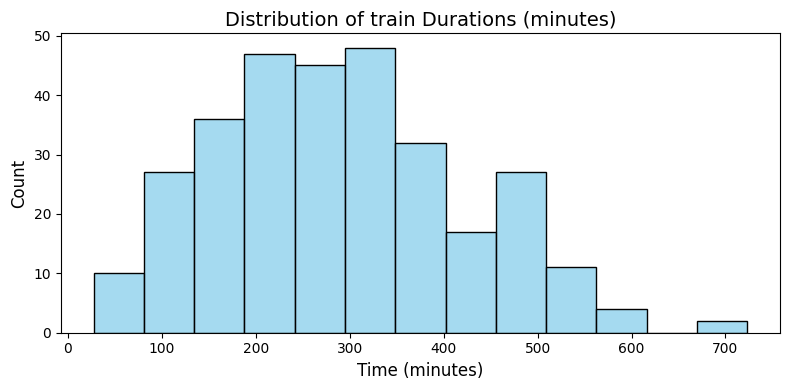

In [11]:
import matplotlib.pyplot as plt
selected_commute_type = "train"
selected_commute_df = df_commutes[df_commutes["commute_type"] == selected_commute_type]
plt.figure(figsize=(8, 4))
sns.histplot(
    selected_commute_df["time_minutes"],
    color="skyblue",
    edgecolor="black"
)
plt.title(f"Distribution of {selected_commute_type} Durations (minutes)", fontsize=14)
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
average_time = selected_commute_df["time_minutes"].mean()
print(f"Average duration for {selected_commute_type} commutes: {average_time:.2f} minutes")

Average duration for train commutes: 290.26 minutes


In [13]:
count_below_50 = (selected_commute_df["time_minutes"] < 45).sum()
print(f"Number of games below 45 minutes: {count_below_50}")
count_above_3h = (selected_commute_df["time_minutes"] > 3*60).sum()
print(f"Number of games above 3 hours: {count_above_3h}")

Number of games below 45 minutes: 4
Number of games above 3 hours: 240


In [14]:
selected_commute_df.sort_values("time_minutes").tail(20)

,trajet,time_minutes,emission_carbone,commute_type,number_of_steps,home_team,away_team
200,Nice;-Rennes,506.900000,530.123,train,2,Nice,Rennes
150,Monaco;-Strasbourg,507.383333,2321.865,train,1,Monaco,Strasbourg
7,Angers;-Monaco,508.000000,492.438,train,3,Angers,Monaco
201,Nice;-Strasbourg,511.216667,2372.754,train,1,Nice,Strasbourg
263,Strasbourg;-Monaco,512.900000,2323.803,train,1,Strasbourg,Monaco
266,Strasbourg;-Nice,514.283333,2372.835,train,1,Strasbourg,Nice
136,Monaco;-Angers,517.183333,489.774,train,3,Monaco,Angers
249,Rennes;-Nice,526.300000,200.042,train,2,Rennes,Nice
246,Rennes;-Monaco,530.033333,548.987,train,3,Rennes,Monaco
61,Le Havre;-Nice,531.083333,566.455,train,3,Le Havre,Nice


### Courbe de décroissance

In [15]:
from pathlib import Path

# Paths
base = Path('/Users/ugo/Documents/MH2D_projets/michlougo/Ligue1')
plane_csv = base / 'Plane calculation' / 'emission_carbone_match.csv'
train_csv = base / 'Train calculation' / 'emission_carbone_match.csv'

# Load data
plane = pd.read_csv(plane_csv)
train = pd.read_csv(train_csv)

# Normalize columns
plane = plane.rename(columns={
    'Hosting team': 'home',
    'visiting team': 'away',
    'Time': 'time_plane_min',
    'emission_carbone': 'emission_plane_kg'
})
train = train.rename(columns={
    'Hosting team': 'home',
    'visiting team': 'away',
    'Time': 'time_train_min',
    'emission_carbone': 'emission_train_kg'
})

# Ensure correct dtypes
for col in ['time_plane_min', 'emission_plane_kg']:
    plane[col] = pd.to_numeric(plane[col], errors='coerce')
for col in ['time_train_min', 'emission_train_kg']:
    train[col] = pd.to_numeric(train[col], errors='coerce')

# If train has multiple routes per matchup, keep the fastest by time_train_min
# The train CSV includes an extra column 'Number of steps' which may vary; we keep the minimal time
train_fastest = (
    train
    .sort_values(['home','away','time_train_min'])
    .groupby(['home','away'], as_index=False)
    .first()
)

# Join plane with fastest train
merged = plane.merge(train_fastest[['home','away','time_train_min','emission_train_kg']], on=['home','away'], how='inner')

# Compute deltas (positive means plane > train for emissions; positive time_delta means train slower)
merged['delta_emission_kg'] = merged['emission_plane_kg'] - merged['emission_train_kg']
merged['delta_time_min'] = merged['time_train_min'] - merged['time_plane_min']

# Order by shortest plane trips first
merged = merged.sort_values('time_plane_min', ascending=True).reset_index(drop=True)

# Cumulative trade-off when replacing n shortest plane trips by train
merged['cum_delta_emission_kg'] = merged['delta_emission_kg'].cumsum()
merged['cum_delta_time_min'] = merged['delta_time_min'].cumsum()

merged['cum_avion_emission_kg'] = merged['emission_plane_kg'].cumsum()
merged['cum_time_plane_min'] = merged['time_plane_min'].cumsum()

merged['cum_train_emission_kg'] = merged['emission_train_kg'].cumsum()
merged['cum_time_train_min'] = merged['time_train_min'].cumsum()

# Select and present columns
result_cols = [
    'home','away','time_plane_min','emission_plane_kg','time_train_min','emission_train_kg',
    'delta_time_min','delta_emission_kg','cum_delta_time_min','cum_delta_emission_kg'
]
tradeoff_df = merged[result_cols]

In [16]:
merged["additional_emission"] = (merged['cum_avion_emission_kg'].max() - (merged['cum_avion_emission_kg'] - merged['cum_train_emission_kg']))
merged["additional_time"] = (merged['cum_time_plane_min'].max() - (merged['cum_time_plane_min'] - merged['cum_time_train_min']))

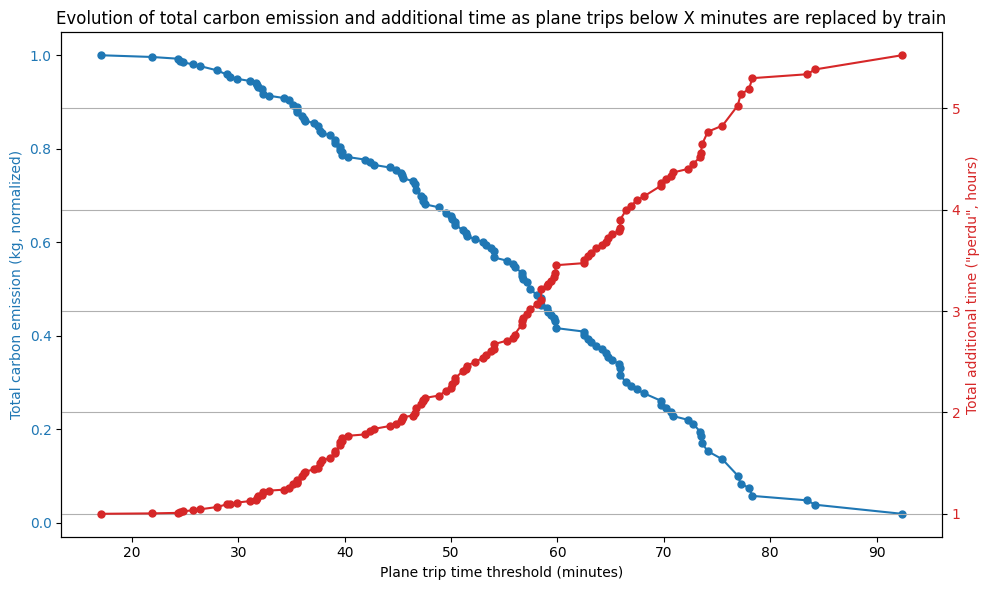

In [18]:
import matplotlib.pyplot as plt

# Prepare data: for each possible time threshold, compute cumulative emission and additional time ("perdu")
thresholds = merged['time_plane_min'].sort_values().unique()
evolution = []

for t in thresholds:
    # For each trip, if plane time <= t, use train, else use plane
    emission = merged.apply(
        lambda row: row['emission_train_kg'] if row['time_plane_min'] <= t else row['emission_plane_kg'],
        axis=1
    ).sum()
    # For each trip, if plane time <= t, additional time
    additional_time = merged.apply(
        lambda row: row['time_train_min'] if row['time_plane_min'] <= t else row['time_plane_min'],
        axis=1
    ).sum()
    evolution.append({
        'threshold_minutes': t/60,
        'total_emission_kg': emission,
        'total_additional_time_min': additional_time/60
    })

evolution_df = pd.DataFrame(evolution)

fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Plane trip time threshold (minutes)')
ax1.set_ylabel('Total carbon emission (kg, normalized)', color=color1)
ax1.plot(
    evolution_df['threshold_minutes'],
    evolution_df['total_emission_kg']/evolution_df['total_emission_kg'].max(),
    marker='o', ms=5, color=color1, label='Normalized Emission'
)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Total additional time ("perdu", hours)', color=color2)
ax2.plot(
    evolution_df['threshold_minutes'],
    evolution_df['total_additional_time_min']/evolution_df['total_additional_time_min'].min(),
    marker='o', ms=5, color=color2, label='Additional Time'
)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Evolution of total carbon emission and additional time as plane trips below X minutes are replaced by train')
fig.tight_layout()
plt.grid(True)
plt.show()

In [21]:
evolution_df

,threshold_minutes,total_emission_kg,total_additional_time_min
0,17.123271,1.054684e+07,16080.634970
1,21.844161,1.050859e+07,16142.663314
2,24.357222,1.046859e+07,16229.148871
3,24.487536,1.042654e+07,16424.123799
4,24.813542,1.038393e+07,16492.696715
...,...,...,...
116,78.004026,7.912668e+05,83442.842462
117,78.323783,6.088265e+05,85187.713998
118,83.477475,5.081883e+05,85808.792382
119,84.206856,4.101145e+05,86566.812003


In [23]:
df_commutes

,trajet,time_minutes,emission_carbone,commute_type,number_of_steps,home_team,away_team
0,Angers;-Auxerre,37.856221,27109.893006,avion,1,Angers,Auxerre
1,Angers;-Brest,40.289710,28226.082993,avion,1,Angers,Brest
2,Angers;-Le Havre,31.806279,25490.388235,avion,1,Angers,Le Havre
3,Angers;-Lens,47.188981,33135.685952,avion,1,Angers,Lens
4,Angers;-Lille,47.188981,31412.905952,avion,1,Angers,Lille
...,...,...,...,...,...,...,...
301,Toulouse;-Paris Saint-Germain,326.666667,420.160000,train,2,Toulouse,Paris Saint-Germain
302,Toulouse;-Reims,454.250000,381.010000,train,2,Toulouse,Reims
303,Toulouse;-Rennes,387.716667,2116.770000,train,1,Toulouse,Rennes
304,Toulouse;-Strasbourg,497.100000,498.242000,train,2,Toulouse,Strasbourg


In [25]:
px.histogram(df_commutes[df_commutes.commute_type == "avion"], x="time_minutes", y='emission_carbone', color="commute_type")

In [30]:
px.line(
    merged, 
    y=['additional_emission',	'additional_time'],
    title="evolution of marginal time and emission"
)

#### N. Plot map

In [8]:
# pd.read_csv("/User/ugo/Documents/MH2D_projets/michlougo/Ligue1/Train calculation/localisation_stade.csv")
location_df = pd.read_csv("../Ligue1/Train calculation/localisation_stade.csv")
location_df.columns = [to_snake_case(col) for col in location_df]

In [9]:
location_df

,unnamed:_0,team,location,stadium,latitude,longitude
0,0,Angers,Angers,Stade Raymond Kopa,47.461000,-0.530717
1,1,Auxerre,Auxerre,Stade Abbé Deschamps,47.786748,3.588546
2,2,Brest,Brest,Stade Francis-Le Blé,48.402886,-4.461457
3,3,Le Havre,Le Havre,Stade Océane,49.499342,0.169294
4,4,Lens,Lens,Stade Bollaert-Delelis,50.432879,2.815084
5,5,Lille,Lille,Decathlon Arena Pierre Mauroy Stadium,50.611355,3.132695
6,6,Lyon,Lyon,Groupama Stadium,45.765217,4.982030
7,7,Marseille,Marseille,Orange Vélodrome,43.269859,5.395901
8,8,Monaco,Monaco Monaco,Stade Louis II,43.727582,7.415604
9,9,Montpellier,Montpellier,Stade de la Mosson,43.622143,3.812063


In [ ]:
# Import des bibliothèques nécessaires pour la visualisation
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

In [ ]:
# Préparation des données pour la carte
# Créer un dictionnaire pour mapper les équipes aux coordonnées
team_coords = {}
for _, row in location_df.iterrows():
    team_coords[row["team"]] = {
        "lat": row["latitude"],
        "lon": row["longitude"],
        "stadium": row["stadium"],
        "location": row["location"],
    }

print("Équipes disponibles:", list(team_coords.keys()))

Équipes disponibles: ['Angers', 'Auxerre', 'Brest', 'Le Havre', 'Lens', 'Lille', 'Lyon', 'Marseille', 'Monaco', 'Montpellier', 'Nantes', 'Nice', 'Paris Saint-Germain', 'Reims', 'Rennes', 'Strasbourg', 'Saint-Étienne', 'Toulouse']


In [ ]:
# Carte simple avec Folium pour les trajets en avion
import folium
import numpy as np

# Filtrer uniquement les trajets en avion
df_avion = df_commutes[df_commutes["commute_type"] == "avion"].copy()

# Calculer l'empreinte carbone moyenne par trajet
trajets_avion = (
    df_avion.groupby(["home_team", "away_team"])["emission_carbone"]
    .mean()
    .reset_index()
)

print(f"Nombre de trajets en avion: {len(trajets_avion)}")
print(
    f"Empreinte carbone moyenne: {trajets_avion['emission_carbone'].mean():.2f} kg CO₂"
)

Nombre de trajets en avion: 306
Empreinte carbone moyenne: 34694.64 kg CO₂


In [ ]:
# Créer la carte Folium
# Centre de la France
m = folium.Map(location=[46.5, 2.5], zoom_start=6)

# Ajouter les marqueurs des équipes
for team, coords in team_coords.items():
    folium.Marker(
        [coords["lat"], coords["lon"]],
        popup=f"<b>{team}</b><br>{coords['stadium']}",
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)

# Ajouter les lignes de trajets en avion
min_emission = trajets_avion["emission_carbone"].min()
max_emission = trajets_avion["emission_carbone"].max()

for _, row in trajets_avion.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]

    if home_team in team_coords and away_team in team_coords:
        # Coordonnées
        home_lat = team_coords[home_team]["lat"]
        home_lon = team_coords[home_team]["lon"]
        away_lat = team_coords[away_team]["lat"]
        away_lon = team_coords[away_team]["lon"]

        # Couleur basée sur l'empreinte carbone
        emission = row["emission_carbone"]
        normalized = (emission - min_emission) / (max_emission - min_emission)

        if normalized < 0.5:
            color = "green"
            weight = 3
        else:
            color = "red"
            weight = 5

        # Ajouter la ligne
        folium.PolyLine(
            locations=[[home_lat, home_lon], [away_lat, away_lon]],
            color=color,
            weight=weight,
            popup=f"{home_team} → {away_team}<br>{emission:.1f} kg CO₂",
        ).add_to(m)